# Задача 4. Многоклассовая классификация и множественная классификация/регрессия

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')  # отключаем предупреждения

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.spatial import distance

# 1. Multiclass classification

## Чтение данных

In [ ]:
df = pd.read_csv('/content/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Возьмём данные продажи домов, которые можно скачать [тут](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).

Описание датасета: <br>

1 - fixed acidity <br>
2 - volatile acidity <br>
3 - citric acid <br>
4 - residual sugar <br>
5 - chlorides <br>
6 - free sulfur dioxide <br>
7 - total sulfur dioxide <br>
8 - density <br>
9 - pH <br>
10 - sulphates <br>
11 - alcohol <br>
12 - quality (score between 0 and 10) <br>

Необходимо решить задачу мультиклассовой классификации. В качестве целевого признака возьмем признак quality, который может иметь классы от 0 до 10.

## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Нулевых значений в полях нет - замену делать не нужно.

Проверим взаимосвязь с целевым признаком:

<Axes: xlabel='quality', ylabel='fixed acidity'>

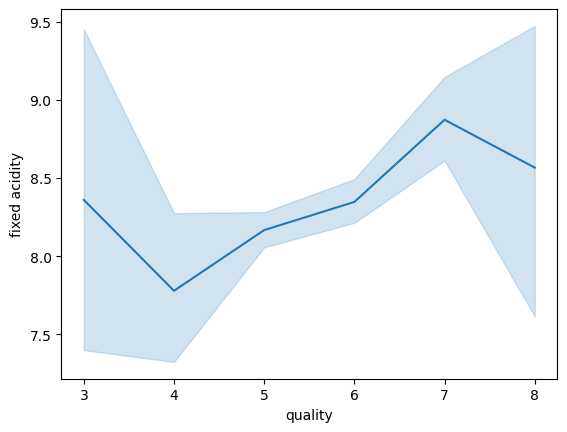

In [ ]:
sns.lineplot(data=df, x="quality", y="fixed acidity")

При повышении фиксированной кислотности до 8,75 у.е. качество вина повышается.

<Axes: xlabel='quality', ylabel='volatile acidity'>

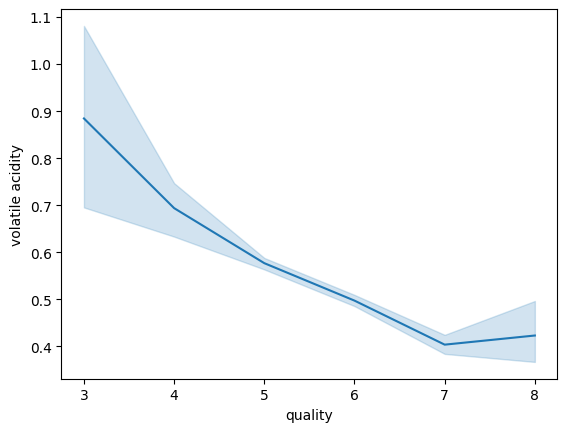

In [ ]:
sns.lineplot(data=df, x="quality", y="volatile acidity")

А повышение летучести уменьшает качество.

<Axes: xlabel='quality', ylabel='citric acid'>

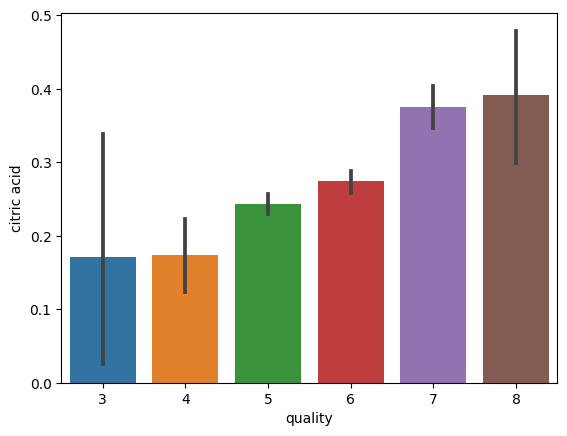

In [ ]:
sns.barplot(data=df, x="quality", y="citric acid")

Повышение лимонной кислоты в среднем повышает рейтинг вина, однако количество низких оценок с большим разбросом показателя не гарантирует это.

<Axes: xlabel='quality', ylabel='residual sugar'>

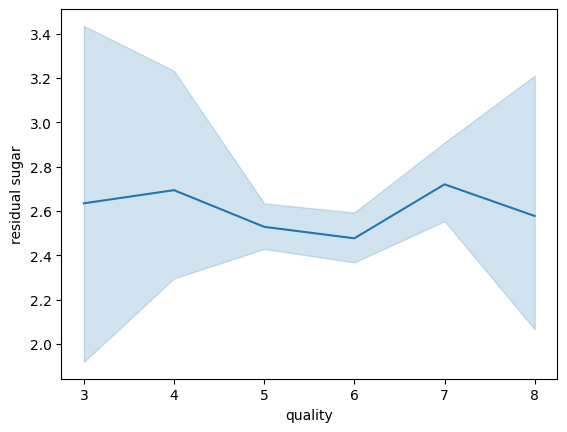

In [ ]:
sns.lineplot(data=df, x="quality", y="residual sugar")

А вот остаточный сахар не признак по которому можно определить коррелляцию с качеством.

<Axes: xlabel='quality', ylabel='chlorides'>

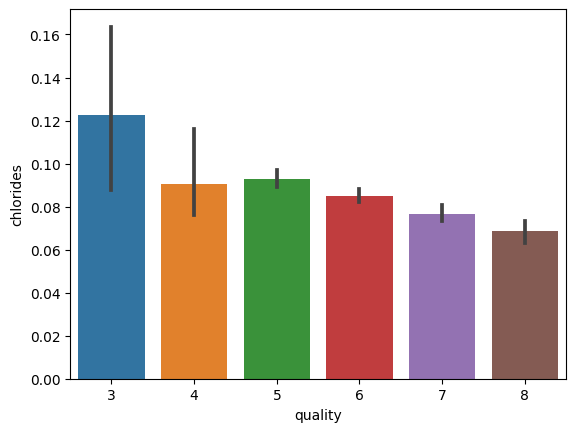

In [ ]:
sns.barplot(data=df, x="quality", y="chlorides")

Можно сказать что понижение уровня хлоридов повышает уровень качества.

<Axes: xlabel='quality', ylabel='free sulfur dioxide'>

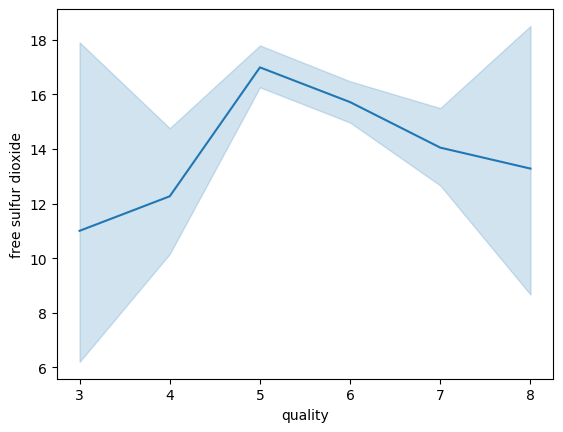

In [ ]:
sns.lineplot(data=df, x="quality", y="free sulfur dioxide")

По признаку свободный диоксид серы нельзя сказать о взаимоотношении с качеством.

<Axes: xlabel='quality', ylabel='total sulfur dioxide'>

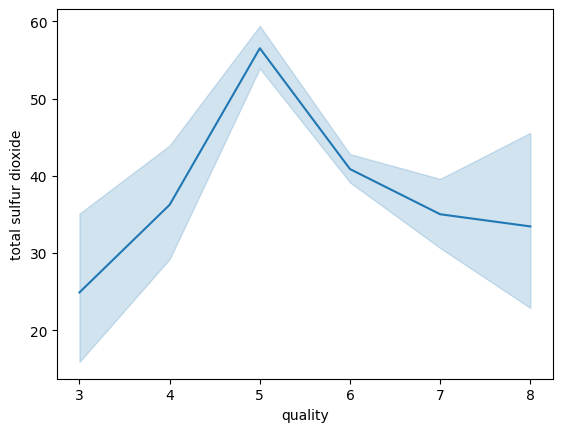

In [ ]:
sns.lineplot(data=df, x="quality", y="total sulfur dioxide")

По признаку общий диоксид серы нельзя сказать о взаимоотношении с качеством.

<Axes: xlabel='quality', ylabel='density'>

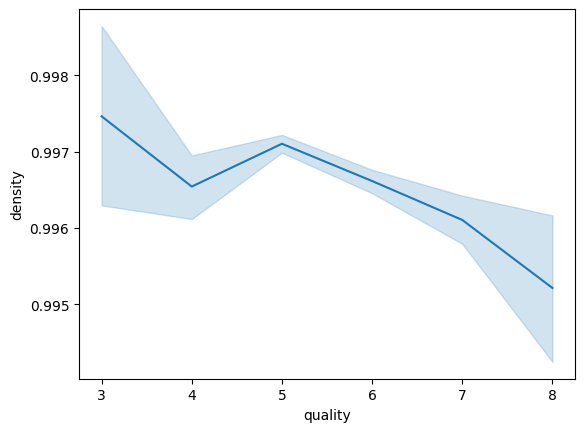

In [ ]:
sns.lineplot(data=df, x="quality", y="density")

Понижение плотности вина приводит к повышению качества.

<Axes: xlabel='quality', ylabel='pH'>

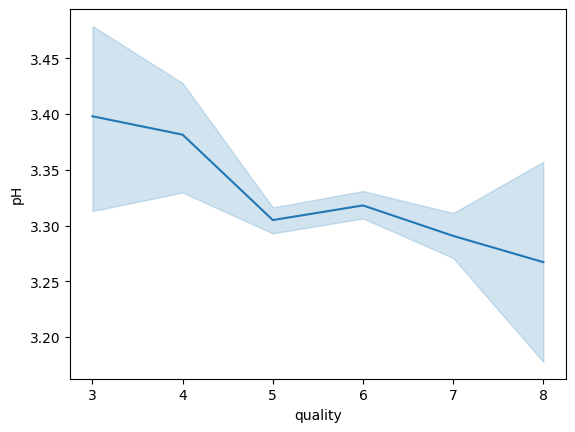

In [ ]:
sns.lineplot(data=df, x="quality", y="pH")

Небольшое понижение кислотности повышает качество

<Axes: xlabel='quality', ylabel='sulphates'>

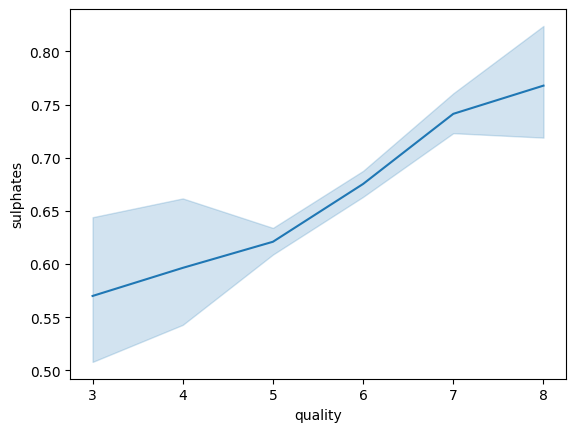

In [ ]:
sns.lineplot(data=df, x="quality", y="sulphates")

Можно точно сказать, что при повышении сульфатов средняя оценка качества растет.

<Axes: xlabel='quality', ylabel='alcohol'>

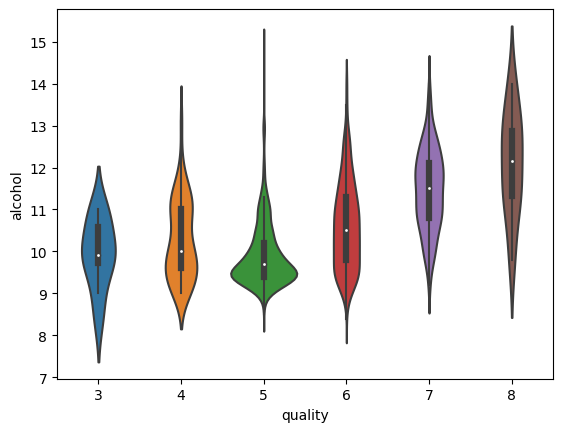

In [ ]:
sns.violinplot(data=df, x="quality", y="alcohol")

Тут можно сказать, что повышение уровня алкоголя до 12.5 градусов - приводит к наилучшей оценке.

<Axes: xlabel='quality', ylabel='count'>

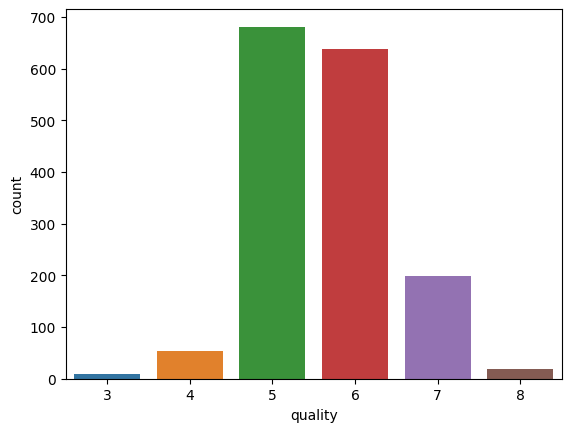

In [ ]:
sns.countplot(data=df, x="quality")

Наибольшее количество оценок вина распределено между 5 и 6 оценками.

Меньше всего представлены оценки 3 и 8, это свидельствует что было проверено очень мало слишком плохих и слишком хороших вин :)

Выведем матрицу корреляции

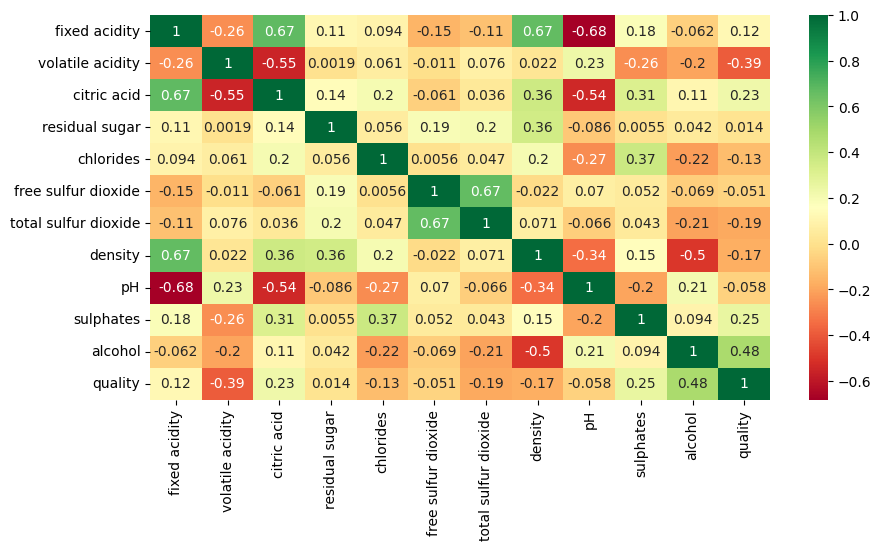

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

## Разбиение данных с использованием train_test_split и масштабирование

In [ ]:
y = df[['quality']]
X = df.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=128)

scaler = StandardScaler()

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(X_train, y_train)

features =  X_train.columns[rfecv.support_]
print("Наилучшее количество признаков -", rfecv.n_features_)
print("Наиболее подходящие признаки -", features)

Наилучшее количество признаков - 11
Наиболее подходящие признаки - Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [ ]:
X_train, X_test = X_train[features], X_test[features]

## Подберем гиперпараметры

In [ ]:
cv = StratifiedKFold(5, shuffle=True, random_state=128)

## SVM from library

In [ ]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Optimal score = 0.6514934336963486


## KNN from library

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'n_neighbors': 9, 'weights': 'distance'}
Optimal score = 0.6711683215887252


## LogisticRegression from library

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 1}
Optimal score = 0.6076753683536195


## Decision Tree from library

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Optimal score = 0.6246836963484946


## Naive Bayes from library

In [ ]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'var_smoothing': 0.4977023564332111}
Optimal score = 0.5942704996796925


## Тестирование обученных моделей

In [ ]:
from sklearn.model_selection import cross_validate


def measure_time(model, X, y):
    return cross_validate(model, X, y, cv=5)["fit_time"].mean()


accuracies = []
times = []
names = []

In [ ]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [ ]:
classes = [5, 6, 7, 4, 8, 3]

6 разных классов качества вина

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(model, predict_func, classifier_title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        func = getattr(model, predict_func)
        print(str(len(X_test)) + " and " + str(len(y_test)))
        print(np.nan_to_num(func(X_test)[:, i]))
        fpr[i], tpr[i], _ = roc_curve([x == i for x in y_test], np.nan_to_num(func(X_test)[:, i]))
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'{classes[i]}-vs-rest (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_title} One-vs-Rest ROC curves')
    plt.legend(loc="lower right")
    plt.show()

## Стратегия **OneVsRest**

### Библиотечная реализация LogisticRegression

In [ ]:
!pip install scikit-plot

OVR_LOGREG accuracy 0.5583333333333333
OVR_LOGREG time 0.07989668846130371


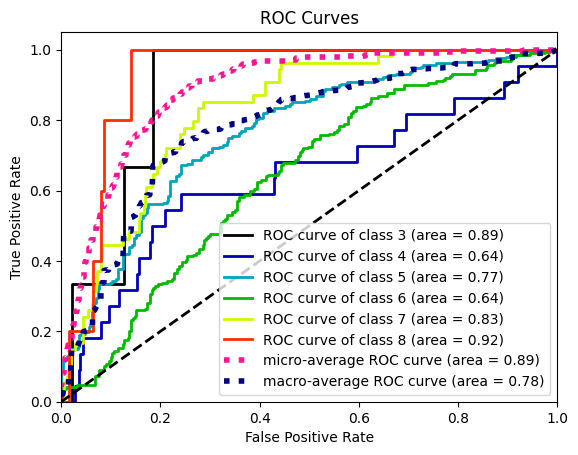

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import scikitplot as skplt

ovr_logreg = OneVsRestClassifier(LogisticRegression(C=optimal_logreg_c, random_state=42)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_logreg.predict(X_test))
time = measure_time(ovr_logreg, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_LOGREG")

print(f"OVR_LOGREG accuracy {accuracy}")
print(f"OVR_LOGREG time {time}")

skplt.metrics.plot_roc_curve(y_test, ovr_logreg.predict_proba(X_test))
plt.show()

### Библиотечная реализация SVM

OVR_SVM accuracy 0.60625
OVR_SVM time 2.8026801109313966


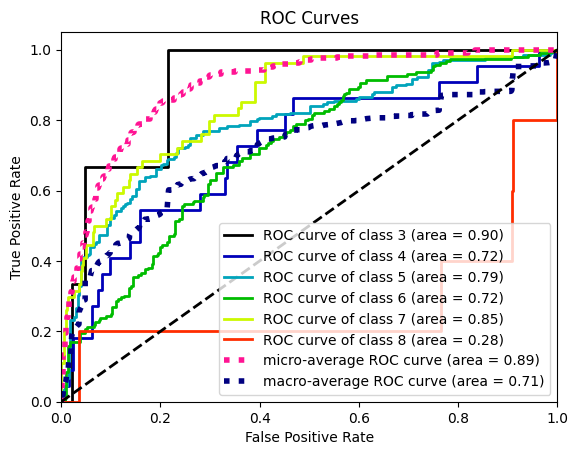

In [ ]:
ovr_svm = OneVsRestClassifier(SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=42, probability=True)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_svm.predict(X_test))
time = measure_time(ovr_svm, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_SVM")

print(f"OVR_SVM accuracy {accuracy}")
print(f"OVR_SVM time {time}")

skplt.metrics.plot_roc_curve(y_test, ovr_svm.predict_proba(X_test))
plt.show()

### Библиотечная реализация KNN

OVR_KNN accuracy 0.525
OVR_KNN time 0.05944280624389649


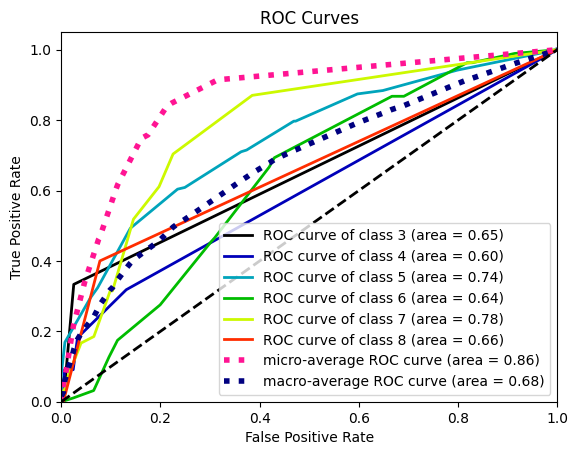

In [ ]:
ovr_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_knn.predict(X_test))
time = measure_time(ovr_knn, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_KNN")

print(f"OVR_KNN accuracy {accuracy}")
print(f"OVR_KNN time {time}")

skplt.metrics.plot_roc_curve(y_test, ovr_knn.predict_proba(X_test))
plt.show()

### Библиотечная реализация Naive Bayes

OVR_NB accuracy 0.5666666666666667
OVR_NB time 0.021775150299072267


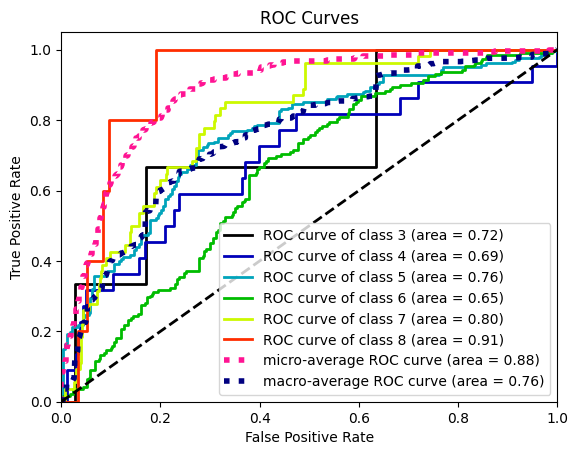

In [ ]:
ovr_nb = OneVsRestClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_nb.predict(X_test))
time = measure_time(ovr_nb, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_NB")

print(f"OVR_NB accuracy {accuracy}")
print(f"OVR_NB time {time}")

skplt.metrics.plot_roc_curve(y_test, ovr_nb.predict_proba(X_test))
plt.show()

### Библиотечная реализация Decision Tree

In [ ]:
ovr_dt = OneVsRestClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                    max_features=optimal_max_features,
                                                    min_samples_leaf=optimal_min_samples_leaf,
                                                    min_samples_split=optimal_min_samples_split,
                                                    splitter=optimal_splitter, random_state=42)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_dt.predict(X_test))
time = measure_time(ovr_dt, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_DT")

print(f"OVR_DT accuracy {accuracy}")
print(f"OVR_DT time {time}")

OVR_DT accuracy 0.5854166666666667
OVR_DT time 0.046771240234375


## Стратегия **OneVsOne**

### Библиотечная реализация LogisticRegression

OVO_LOGREG accuracy 0.5770833333333333
OVO_LOGREG time 0.08123292922973632


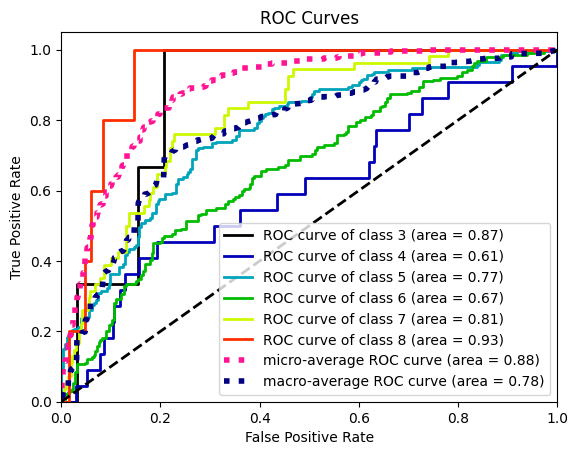

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

ovo_logreg = OneVsOneClassifier(LogisticRegression(C=optimal_logreg_c, random_state=42)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_logreg.predict(X_test))
time = measure_time(ovo_logreg, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_LOGREG")

print(f"OVO_LOGREG accuracy {accuracy}")
print(f"OVO_LOGREG time {time}")

skplt.metrics.plot_roc_curve(y_test, ovo_logreg.decision_function(X_test))
plt.show()

### Библиотечная реализация SVM

OVO_SVM accuracy 0.6229166666666667
OVO_SVM time 1.1840461254119874


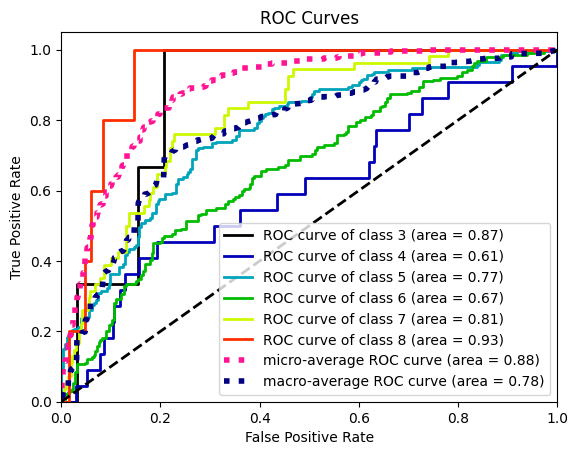

In [ ]:
ovo_svm = OneVsOneClassifier(SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=42, probability=True)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_svm.predict(X_test))
time = measure_time(ovo_svm, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_SVM")

print(f"OVO_SVM accuracy {accuracy}")
print(f"OVO_SVM time {time}")

skplt.metrics.plot_roc_curve(y_test, ovo_logreg.decision_function(X_test))
plt.show()

### Библиотечная реализация KNN

OVO_KNN accuracy 0.5375
OVO_KNN time 0.056926631927490236


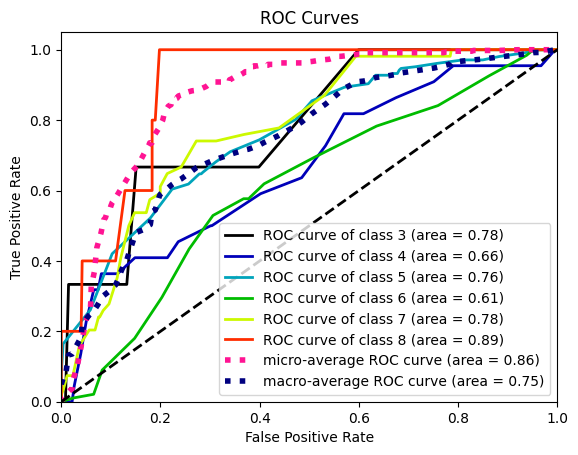

In [ ]:
ovo_knn = OneVsOneClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_knn.predict(X_test))
time = measure_time(ovo_knn, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_KNN")

print(f"OVO_KNN accuracy {accuracy}")
print(f"OVO_KNN time {time}")

skplt.metrics.plot_roc_curve(y_test, ovo_knn.decision_function(X_test))
plt.show()

### Библиотечная реализация Naive Bayes

OVO_NB accuracy 0.5666666666666667
OVO_NB time 0.052300453186035156


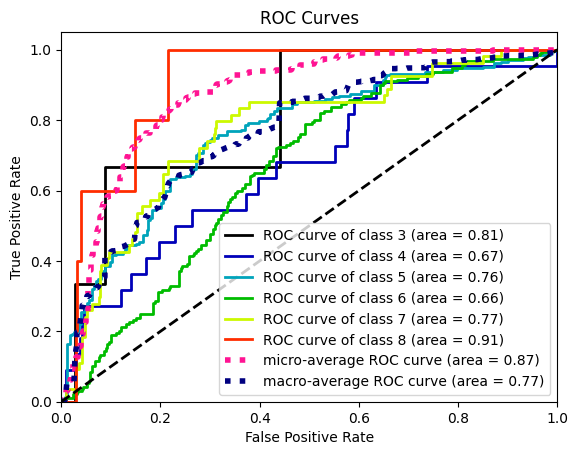

In [ ]:
ovo_nb = OneVsOneClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_nb.predict(X_test))
time = measure_time(ovo_nb, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_NB")

print(f"OVO_NB accuracy {accuracy}")
print(f"OVO_NB time {time}")

skplt.metrics.plot_roc_curve(y_test, ovo_nb.decision_function(X_test))
plt.show()

### Библиотечная реализация Decision Tree

OVO_DT accuracy 0.5333333333333333
OVO_DT time 0.22338638305664063


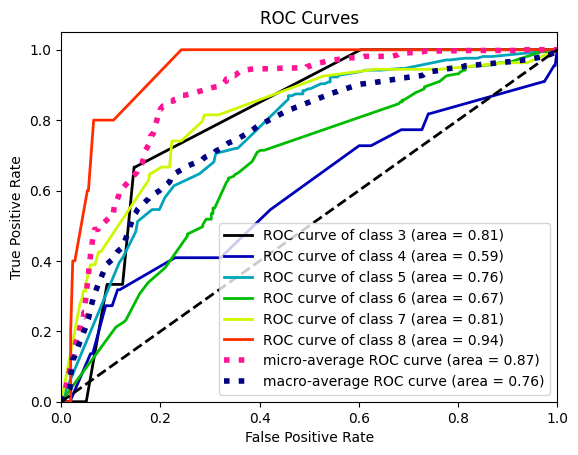

In [ ]:
ovo_dt = OneVsOneClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                   max_features=optimal_max_features,
                                                   min_samples_leaf=optimal_min_samples_leaf,
                                                   min_samples_split=optimal_min_samples_split,
                                                   splitter=optimal_splitter, random_state=42)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_dt.predict(X_test))
time = measure_time(ovo_dt, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_DT")

print(f"OVO_DT accuracy {accuracy}")
print(f"OVO_DT time {time}")

skplt.metrics.plot_roc_curve(y_test, ovo_dt.decision_function(X_test))
plt.show()

## Стратегия **OutputCode**

### Библиотечная реализация LogisticRegression

In [ ]:
from sklearn.multiclass import OutputCodeClassifier

oc_logreg = OutputCodeClassifier(LogisticRegression(C=optimal_logreg_c, random_state=42)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_logreg.predict(X_test))
time = measure_time(oc_logreg, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_LOGREG")

print(f"OC_LOGREG accuracy {accuracy}")
print(f"OC_LOGREG time {time}")

OC_LOGREG accuracy 0.575
OC_LOGREG time 0.5437641143798828


### Библиотечная реализация SVM

In [ ]:
oc_svm = OutputCodeClassifier(
    SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=42, probability=True)).fit(X_train,
                                                                                                             y_train)
accuracy = accuracy_score(y_test, oc_svm.predict(X_test))
time = measure_time(oc_svm, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_SVM")

print(f"OC_SVM accuracy {accuracy}")
print(f"OC_SVM time {time}")

OC_SVM accuracy 0.6041666666666666
OC_SVM time 3.5621102333068846


### Библиотечная реализация KNN

In [ ]:
oc_knn = OutputCodeClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_knn.predict(X_test))
time = measure_time(oc_knn, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_KNN")

print(f"OC_KNN accuracy {accuracy}")
print(f"OC_KNN time {time}")

OC_KNN accuracy 0.5
OC_KNN time 0.024161338806152344


### Библиотечная реализация Naive Bayes

In [ ]:
oc_nb = OutputCodeClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_nb.predict(X_test))
time = measure_time(oc_nb, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_NB")

print(f"OC_NB accuracy {accuracy}")
print(f"OC_NB time {time}")

OC_NB accuracy 0.5666666666666667
OC_NB time 0.021601486206054687


### Библиотечная реализация Decision Tree

In [ ]:
oc_dt = OutputCodeClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                    max_features=optimal_max_features,
                                                    min_samples_leaf=optimal_min_samples_leaf,
                                                    min_samples_split=optimal_min_samples_split,
                                                    splitter=optimal_splitter, random_state=42)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_dt.predict(X_test))
time = measure_time(oc_dt, X_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_DT")

print(f"OC_DT accuracy {accuracy}")
print(f"OC_DT time {time}")

OC_DT accuracy 0.61875
OC_DT time 0.061547279357910156


## Сравнение обученных моделей

### Точность

In [ ]:
accuracy_df = pd.DataFrame(list(zip(names, accuracies)), columns=['Name', 'Accuracy'])

In [ ]:
accuracy_logreg_df = pd.DataFrame(list(zip(names[0::5], accuracies[0::5])), columns=['Name', 'Accuracy'])
accuracy_svm_df = pd.DataFrame(list(zip(names[1::5], accuracies[1::5])), columns=['Name', 'Accuracy'])
accuracy_knn_df = pd.DataFrame(list(zip(names[2::5], accuracies[2::5])), columns=['Name', 'Accuracy'])
accuracy_nb_df = pd.DataFrame(list(zip(names[3::5], accuracies[3::5])), columns=['Name', 'Accuracy'])
accuracy_dt_df = pd.DataFrame(list(zip(names[4::5], accuracies[4::5])), columns=['Name', 'Accuracy'])

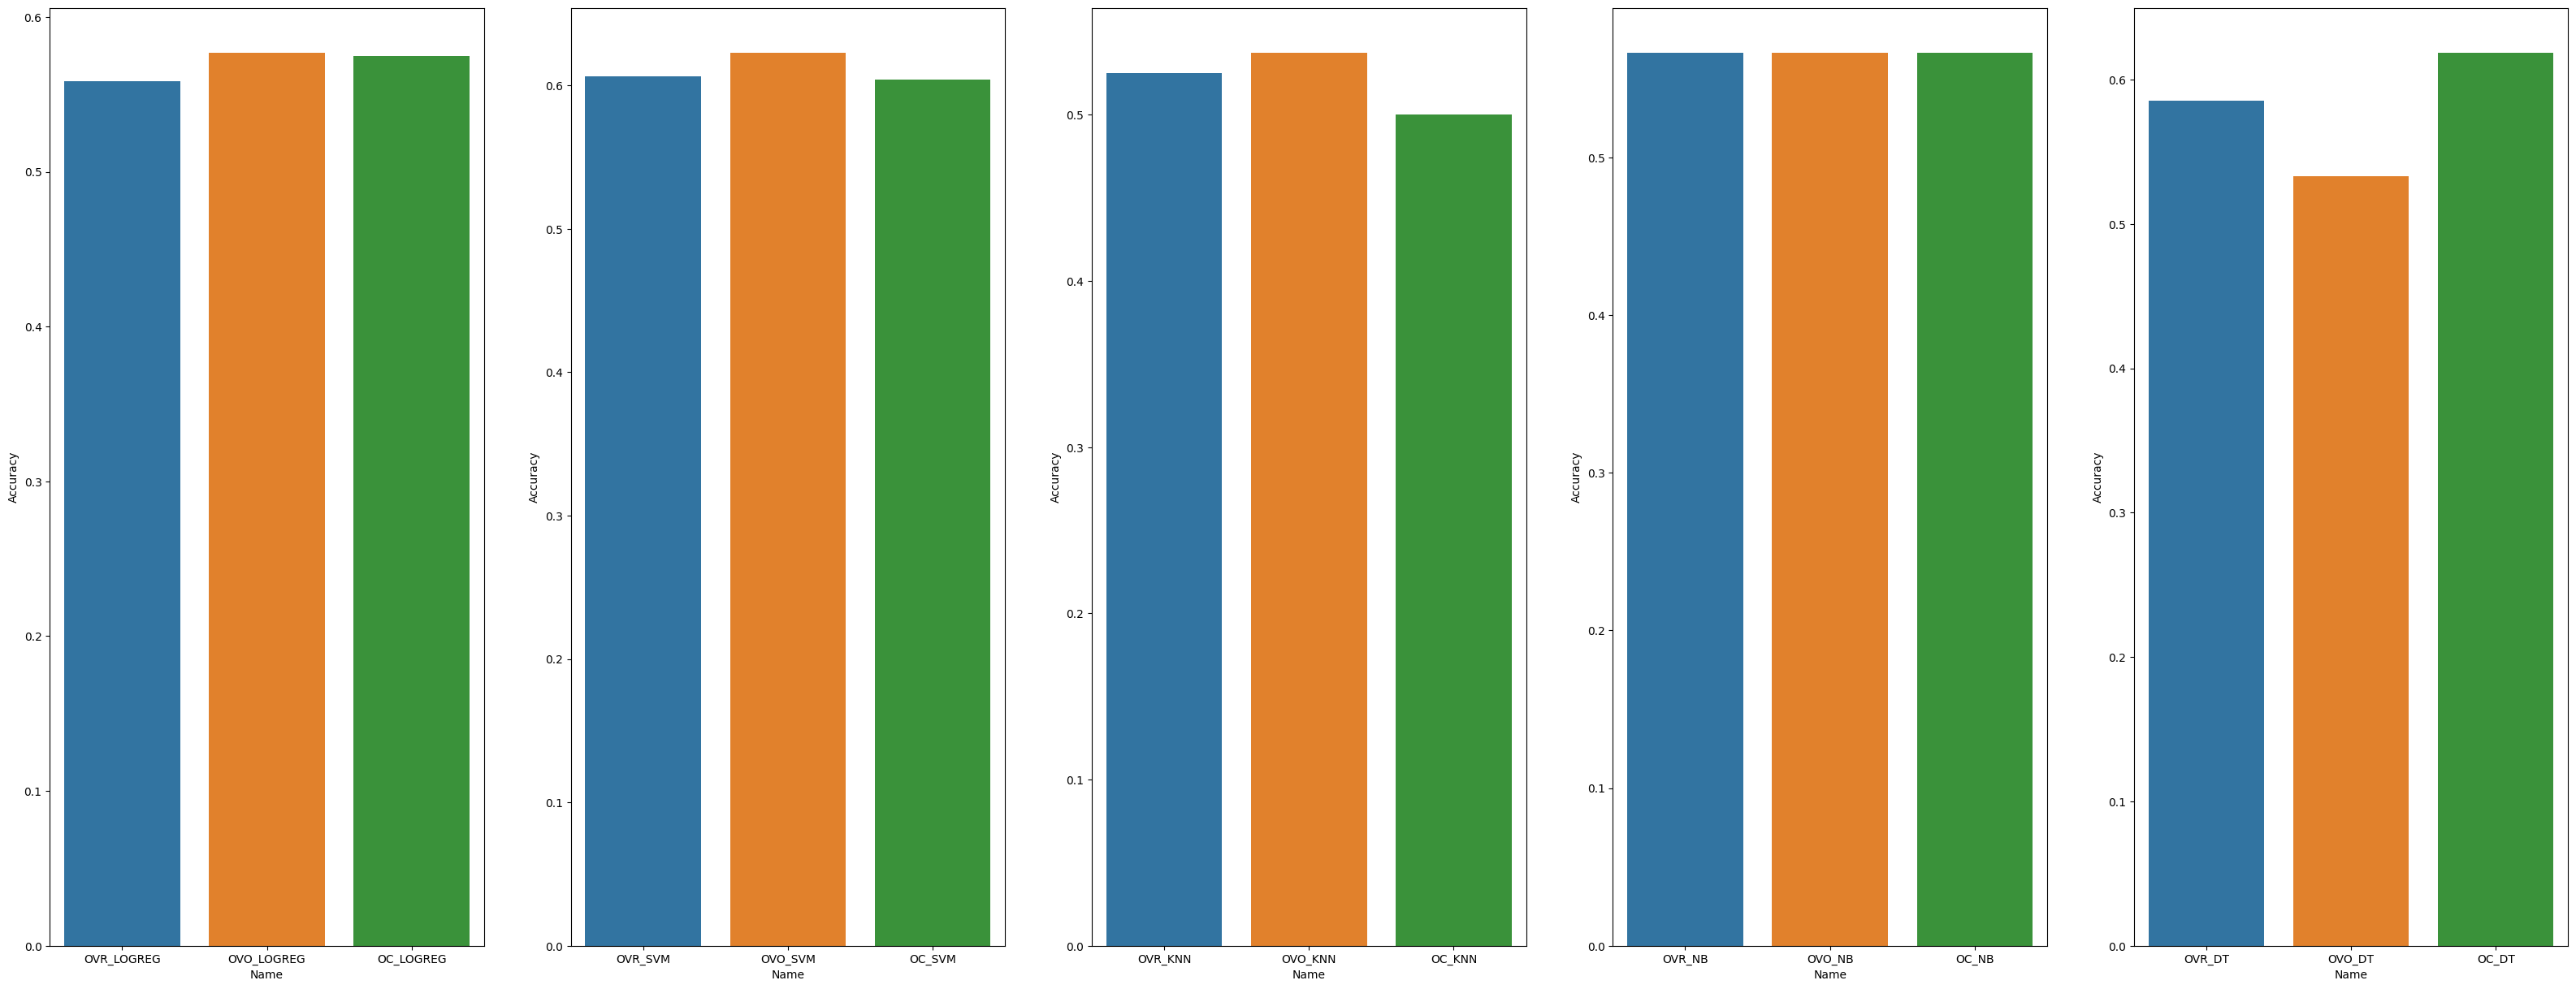

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(40, 15))
sns.barplot(accuracy_logreg_df, x='Name', y='Accuracy', palette="tab10", ax=axs[0])
sns.barplot(accuracy_svm_df, x='Name', y='Accuracy', palette="tab10", ax=axs[1])
sns.barplot(accuracy_knn_df, x='Name', y='Accuracy', palette="tab10", ax=axs[2])
sns.barplot(accuracy_nb_df, x='Name', y='Accuracy', palette="tab10", ax=axs[3])
sns.barplot(accuracy_dt_df, x='Name', y='Accuracy', palette="tab10", ax=axs[4])
plt.show()

### Время

In [ ]:
time_logreg_df = pd.DataFrame(list(zip(names[0::5], times[0::5])), columns=['Name', 'Time'])
time_svm_df = pd.DataFrame(list(zip(names[1::5], times[1::5])), columns=['Name', 'Time'])
time_knn_df = pd.DataFrame(list(zip(names[2::5], times[2::5])), columns=['Name', 'Time'])
time_nb_df = pd.DataFrame(list(zip(names[3::5], times[3::5])), columns=['Name', 'Time'])
time_dt_df = pd.DataFrame(list(zip(names[4::5], times[4::5])), columns=['Name', 'Time'])

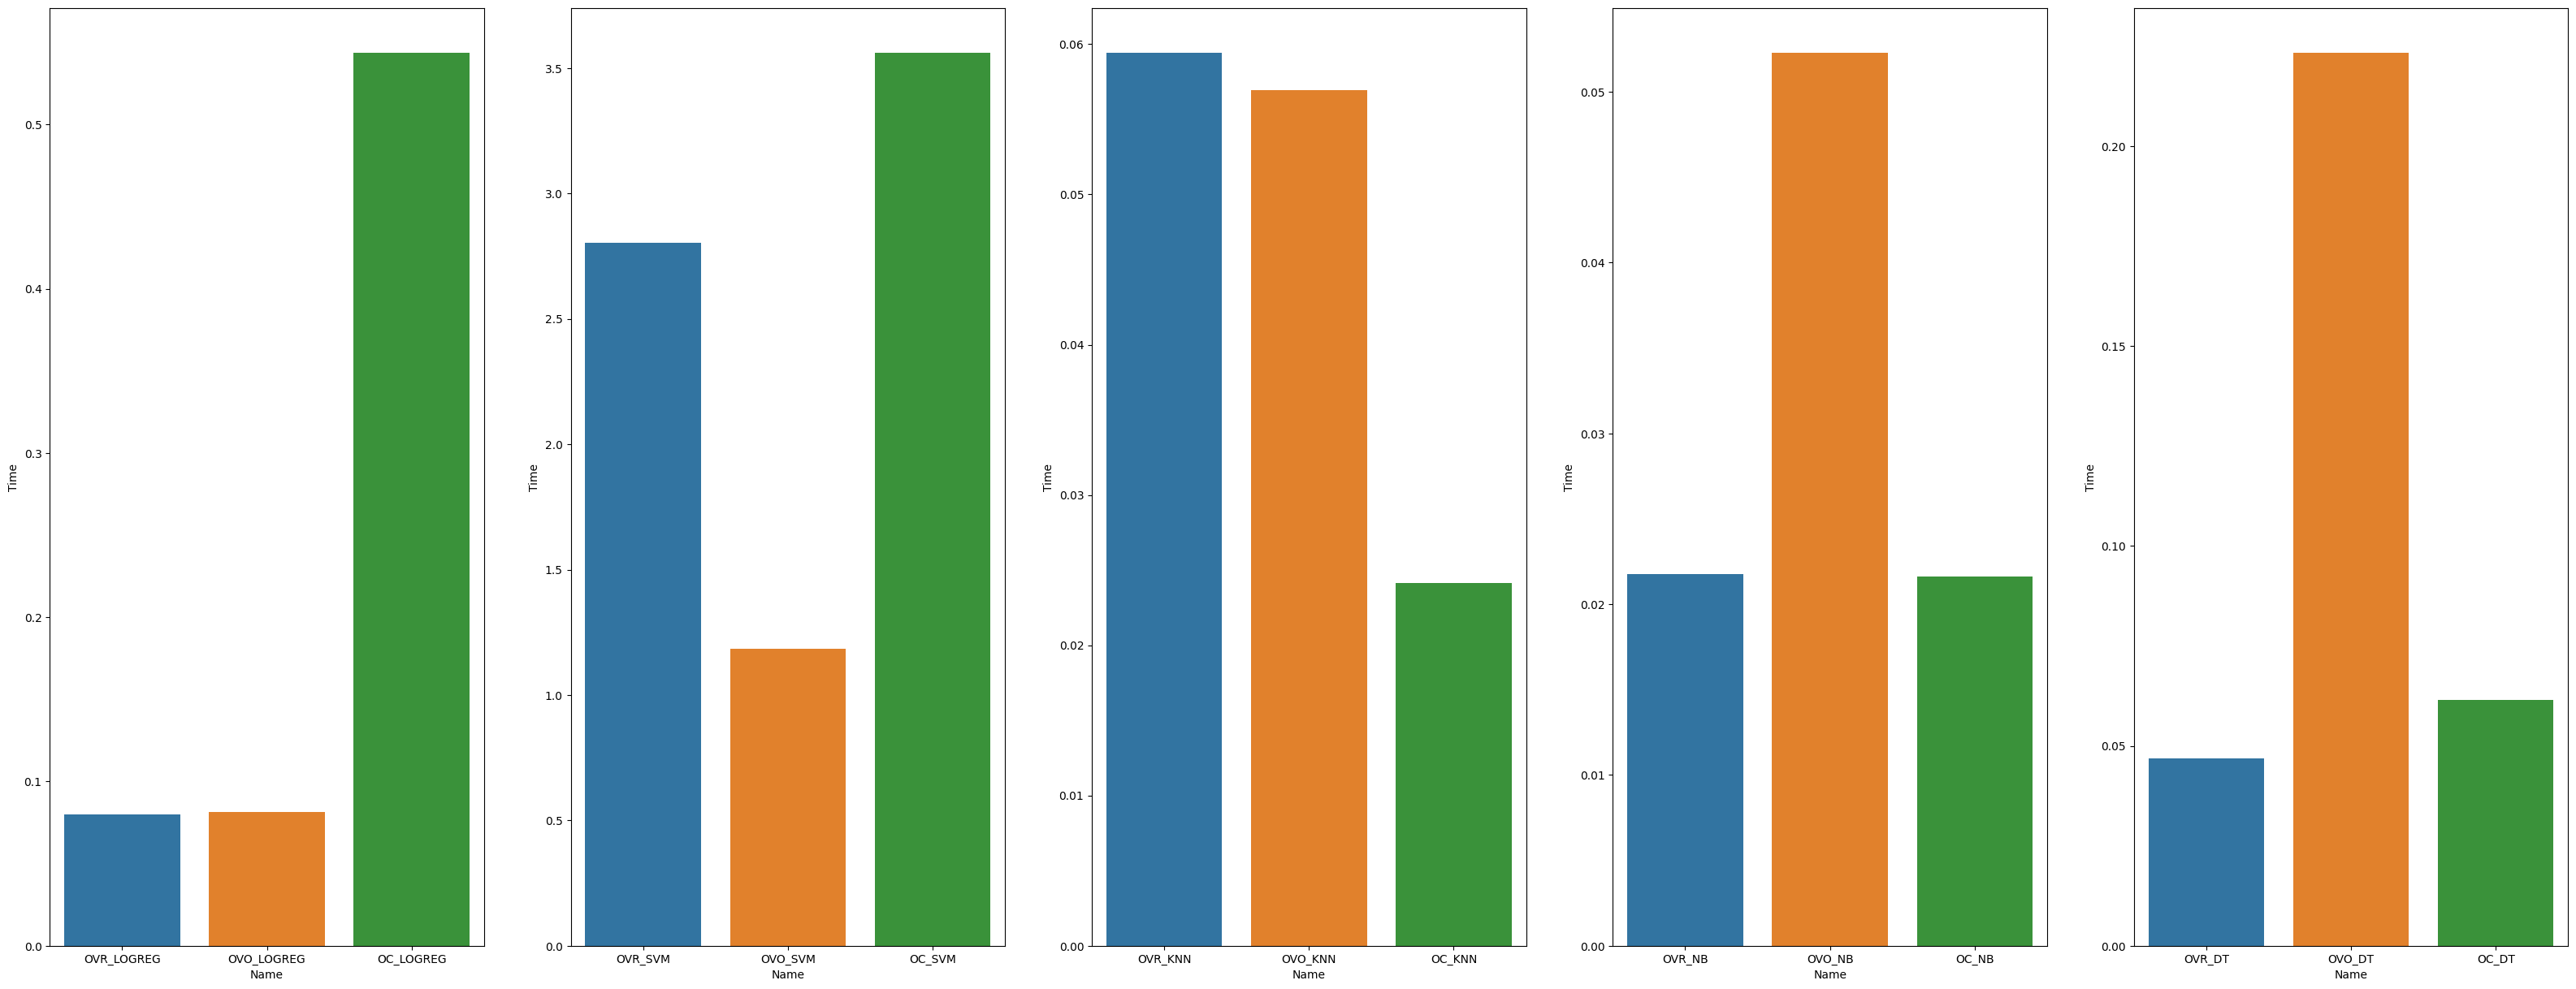

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(40, 15))
sns.barplot(time_logreg_df, x='Name', y='Time', palette="tab10", ax=axs[0])
sns.barplot(time_svm_df, x='Name', y='Time', palette="tab10", ax=axs[1])
sns.barplot(time_knn_df, x='Name', y='Time', palette="tab10", ax=axs[2])
sns.barplot(time_nb_df, x='Name', y='Time', palette="tab10", ax=axs[3])
sns.barplot(time_dt_df, x='Name', y='Time', palette="tab10", ax=axs[4])
plt.show()

### Вывод
Для текущего датасета:

LogisticRegression:
По точности лидером является OneVsOne, так же он имеет релевантное время выполнения.
Проиграл по времени метод OutputCode.

SVM:
По точности лидером является OneVsOne, так же он имеет релевантное время выполнения.
Заметно проиграл по времени и точности метод OutputCode.

KNN:
По точности лидером является OneVsOne, однако он имеет достаточно большое время выполнения.
Лучше выбрать метод OutputCode, который быстрее выполняется в 2 раза чем остальные методы и не сильно проигрывает по точности.

Naive Bayes:
Все методы имеют примерно одинаковую точность, однако по времени выполнения в 2 раза проигрывает OneVsOne.

Decision Tree:
По точности лидером является OutputCode, так же он имеет релевантное время выполнения.
Сильно проигрывает по точности и времени метод OneVsOne.

Итого можно сказать, что для данного датасета релевантнее всего использовать предсказание OneVsOne вместе с SVM алгоритмом. Хуже всего использование OutputCode вместе с SVM алгоритмом.



# 2.Multilabel classification

Возьмём данные продажи домов, которые можно скачать [тут](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

Описание датасета: <br>

1. Age : Age of the patient

2. Sex : Sex of the patient (0 - female, 1 - male)

3. cp : Chest Pain type chest pain type

Value 1: typical angina <br>
Value 2: atypical angina <br>
Value 3: non-anginal pain <br>
Value 4: asymptomatic <br>

4. trtbps : resting blood pressure (in mm Hg)

5. chol : cholestoral in mg/dl fetched via BMI sensor

6. fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

7. restecg : resting electrocardiographic results

Value 0: normal<br>
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)<br>
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria<br>

8. thalach : maximum heart rate achieved

9. exng: exercise induced angina (1 = yes; 0 = no)

10. oldpeak : Previous peak

11. slp : Slope

12. caa : number of major vessels (0-3)

13. thall : Thal rate

14. output : 0= less chance of heart attack 1= more chance of heart attack

Необходимо решить задачу мультилейбл классификации. В качестве целевых признаков возьмем бинарные признаки sex и output, тем самым решим задачу классификации для проблем с сердцем для обоих полов.

In [193]:
df = pd.read_csv('/content/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [195]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Статистика целевых признаков:

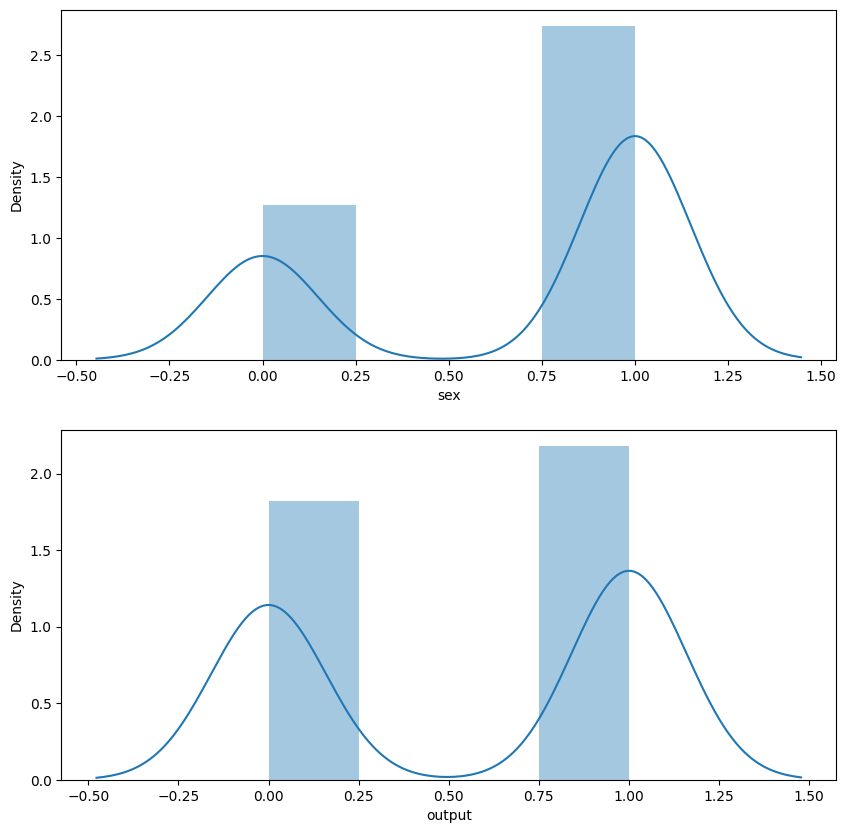

In [201]:
_, ax = plt.subplots(2, 1, figsize=(10,10))
sns.distplot(df['sex'], ax=ax[0])
sns.distplot(df['output'], ax=ax[1])
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

Мужчин участвовало в выборке больше чем женщин, а вот результаты вероятности проблем с сердцем примерно одинаковы.

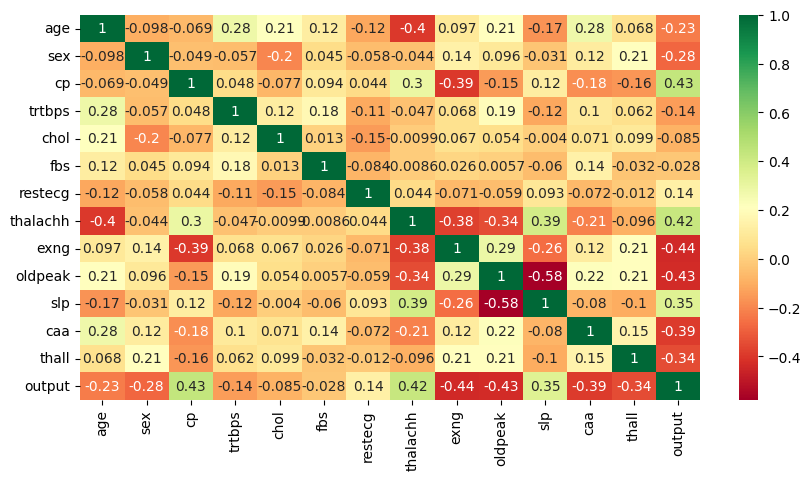

In [202]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Среди большого количества призннаков можно заметить как и коррелирующие признаки, так и не коррелирующие. А значит задача классификации будет актуальна.э

## Разбиение данных с использованием train_test_split и масштабирование

In [203]:
y = df[['sex', 'output']]
X = df.drop(columns=['sex', 'output'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=128)

scaler = StandardScaler()

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [204]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [205]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(X_train, y_train)

print("Наилучшее количество признаков -", rfecv.n_features_)
print("Наиболее подходящие признаки -", X_train.columns[rfecv.support_])

Наилучшее количество признаков - 12
Наиболее подходящие признаки - Index(['age', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng',
       'oldpeak', 'slp', 'caa', 'thall'],
      dtype='object')


In [206]:
X_train, X_test = X_train[ X_train.columns[rfecv.support_]], X_test[ X_train.columns[rfecv.support_]]

## Подберем гиперпараметры

Подбор гиперпараметров будем производить по двум признакам отдельно, а по итоговой точности выберем лучшие параметры.

In [207]:
cv = StratifiedKFold(5, shuffle=True, random_state=128)
y_train_1 = y_train['sex']
y_train_2 = y_train['output']

## SVM from library

In [208]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=128), param_grid=param_grid, cv=cv)

print("First feature:")
searcher = searcher.fit(X_train, y_train_1)

optimal_kernel_1 = searcher.best_params_["kernel"]
optimal_svm_c_1 = searcher.best_params_["C"]
optimal_gamma_1 = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

print("Second feature:")
searcher = searcher.fit(X_train, y_train_2)

optimal_kernel_2 = searcher.best_params_["kernel"]
optimal_svm_c_2 = searcher.best_params_["C"]
optimal_gamma_2 = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

First feature:
Optimal params = {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Optimal score = 0.7313399778516058
Second feature:
Optimal params = {'C': 0.25, 'gamma': 'scale', 'kernel': 'linear'}
Optimal score = 0.8204872646733111


## KNN from library

In [209]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv)

print("First feature:")
searcher = searcher.fit(X_train, y_train_1)

optimal_n_neighbors_1 = searcher.best_params_["n_neighbors"]
optimal_weights_1 = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

print("Second feature:")
searcher = searcher.fit(X_train, y_train_2)

optimal_n_neighbors_2 = searcher.best_params_["n_neighbors"]
optimal_weights_2 = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

First feature:
Optimal params = {'n_neighbors': 17, 'weights': 'distance'}
Optimal score = 0.7359911406423034
Second feature:
Optimal params = {'n_neighbors': 17, 'weights': 'distance'}
Optimal score = 0.8068660022148395


## LogisticRegression from library

In [210]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=128), param_grid=param_grid, cv=cv)

print("First feature:")
searcher = searcher.fit(X_train, y_train_1)

optimal_logreg_c_1 = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

print("Second feature:")
searcher = searcher.fit(X_train, y_train_2)

optimal_logreg_c_2 = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

First feature:
Optimal params = {'C': 1}
Optimal score = 0.7264673311184938
Second feature:
Optimal params = {'C': 0.1}
Optimal score = 0.8349944629014396


## Decision Tree from library

In [211]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=128), param_grid=param_grid, cv=cv)

print("First feature:")
searcher = searcher.fit(X_train, y_train_1)

optimal_criterion_1 = searcher.best_params_["criterion"]
optimal_splitter_1 = searcher.best_params_["splitter"]
optimal_max_depth_1 = searcher.best_params_["max_depth"]
optimal_min_samples_split_1 = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf_1 = searcher.best_params_["min_samples_leaf"]
optimal_max_features_1 = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

print("Second feature:")
searcher = searcher.fit(X_train, y_train_2)

optimal_criterion_2 = searcher.best_params_["criterion"]
optimal_splitter_2 = searcher.best_params_["splitter"]
optimal_max_depth_2 = searcher.best_params_["max_depth"]
optimal_min_samples_split_2 = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf_2 = searcher.best_params_["min_samples_leaf"]
optimal_max_features_2 = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

First feature:
Optimal params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Optimal score = 0.7362126245847176
Second feature:
Optimal params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}
Optimal score = 0.8021040974529348


## Naive Bayes from library

In [212]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv)

print("First feature:")
searcher = searcher.fit(X_train, y_train_1)

optimal_var_smoothing_1 = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

print("Second feature:")
searcher = searcher.fit(X_train, y_train_2)

optimal_var_smoothing_2 = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

First feature:
Optimal params = {'var_smoothing': 0.6280291441834253}
Optimal score = 0.7217054263565892
Second feature:
Optimal params = {'var_smoothing': 0.24770763559917108}
Optimal score = 0.816389811738649


## Тестирование обученных моделей

In [244]:
accuracies = []
times = []
names = []

### Библиотечная реализация LogisticRegression

In [245]:
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

moc_logreg_1 = MultiOutputClassifier(LogisticRegression(C=optimal_logreg_c_1, random_state=42)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, moc_logreg_1.predict(X_test))
time_1 = measure_time(moc_logreg_1, X_train, y_train)

moc_logreg_2 = MultiOutputClassifier(LogisticRegression(C=optimal_logreg_c_2, random_state=42)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, moc_logreg_2.predict(X_test))
time_2 = measure_time(moc_logreg_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  moc_logreg = moc_logreg_1
  accuracy = accuracy_1
  time = time_1
else:
  moc_logreg = moc_logreg_2
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("MOC_LOGREG")

print(f"MOC_LOGREG accuracy {accuracy}")
print(f"MOC_LOGREG time {time}")

MOC_LOGREG accuracy 0.5384615384615384
MOC_LOGREG time 0.011339044570922852


In [246]:
from sklearn.metrics import accuracy_score
from sklearn.multioutput import ClassifierChain

cc_logreg_1 = ClassifierChain(LogisticRegression(C=optimal_logreg_c_1, random_state=42)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, cc_logreg_1.predict(X_test))
time_1 = measure_time(cc_logreg_1, X_train, y_train)

cc_logreg_2 = ClassifierChain(LogisticRegression(C=optimal_logreg_c_2, random_state=42)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, cc_logreg_2.predict(X_test))
time_2 = measure_time(cc_logreg_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("CC_LOGREG")

print(f"CC_LOGREG accuracy {accuracy}")
print(f"CC_LOGREG time {time}")

CC_LOGREG accuracy 0.5384615384615384
CC_LOGREG time 0.011673402786254884


### Библиотечная реализация SVM

In [247]:
moc_svm_1 = MultiOutputClassifier(SVC(kernel=optimal_kernel_1, C=optimal_svm_c_1, gamma=optimal_gamma_1, random_state=42, probability=True)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, moc_svm_1.predict(X_test))
time_1 = measure_time(moc_svm_1, X_train, y_train)

moc_svm_2 = MultiOutputClassifier(SVC(kernel=optimal_kernel_2, C=optimal_svm_c_2, gamma=optimal_gamma_2, random_state=42, probability=True)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, moc_svm_2.predict(X_test))
time_2 = measure_time(moc_svm_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("MOC_SVM")

print(f"MOC_SVM accuracy {accuracy}")
print(f"MOC_SVM time {time}")

MOC_SVM accuracy 0.5164835164835165
MOC_SVM time 0.028865718841552736


In [248]:
cc_svm_1 = ClassifierChain(SVC(kernel=optimal_kernel_1, C=optimal_svm_c_1, gamma=optimal_gamma_1, random_state=42, probability=True)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, cc_svm_1.predict(X_test))
time_1 = measure_time(cc_svm_1, X_train, y_train)

cc_svm_2 = ClassifierChain(SVC(kernel=optimal_kernel_2, C=optimal_svm_c_2, gamma=optimal_gamma_2, random_state=42, probability=True)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, cc_svm_2.predict(X_test))
time_2 = measure_time(cc_svm_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("CC_SVM")

print(f"CC_SVM accuracy {accuracy}")
print(f"CC_SVM time {time}")

CC_SVM accuracy 0.5164835164835165
CC_SVM time 0.04060463905334473


### Библиотечная реализация KNN

In [249]:
moc_knn_1 = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors_1)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, moc_knn_1.predict(X_test))
time_1 = measure_time(moc_knn_1, X_train, y_train)

moc_knn_2 = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors_2)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, moc_knn_2.predict(X_test))
time_2 = measure_time(moc_knn_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("MOC_KNN")

print(f"MOC_KNN accuracy {accuracy}")
print(f"MOC_KNN time {time}")

MOC_KNN accuracy 0.5714285714285714
MOC_KNN time 0.005803442001342774


In [250]:
cc_knn_1 = ClassifierChain(KNeighborsClassifier(n_neighbors=optimal_n_neighbors_1)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, cc_knn_1.predict(X_test))
time_1 = measure_time(cc_knn_1, X_train, y_train)

cc_knn_2 = ClassifierChain(KNeighborsClassifier(n_neighbors=optimal_n_neighbors_2)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, cc_knn_2.predict(X_test))
time_2 = measure_time(cc_knn_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("CC_KNN")

print(f"CC_KNN accuracy {accuracy}")
print(f"CC_KNN time {time}")

CC_KNN accuracy 0.5494505494505495
CC_KNN time 0.004895973205566406


### Библиотечная реализация Naive Bayes

In [251]:
moc_nb_1 = MultiOutputClassifier(GaussianNB(var_smoothing=optimal_var_smoothing_1)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, moc_nb_1.predict(X_test))
time_1 = measure_time(moc_nb_1, X_train, y_train)

moc_nb_2 = MultiOutputClassifier(GaussianNB(var_smoothing=optimal_var_smoothing_1)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, moc_nb_2.predict(X_test))
time_2 = measure_time(moc_nb_2, X_train, y_train)


if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("MOC_NB")

print(f"MOC_NB accuracy {accuracy}")
print(f"MOC_NB time {time}")

MOC_NB accuracy 0.5054945054945055
MOC_NB time 0.005547237396240234


In [252]:
cc_nb_1 = ClassifierChain(GaussianNB(var_smoothing=optimal_var_smoothing_1)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, cc_nb_1.predict(X_test))
time_1 = measure_time(cc_nb_1, X_train, y_train)

cc_nb_2 = ClassifierChain(GaussianNB(var_smoothing=optimal_var_smoothing_1)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, cc_nb_2.predict(X_test))
time_2 = measure_time(cc_nb_2, X_train, y_train)


if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("CC_NB")

print(f"CC_NB accuracy {accuracy}")
print(f"CC_NB time {time}")

CC_NB accuracy 0.5164835164835165
CC_NB time 0.006457805633544922


### Библиотечная реализация Decision Tree

In [253]:
moc_dt_1 = MultiOutputClassifier(DecisionTreeClassifier(criterion=optimal_criterion_1,
                                                        max_depth=optimal_max_depth_1,
                                                    max_features=optimal_max_features_1,
                                                    min_samples_leaf=optimal_min_samples_leaf_1,
                                                    min_samples_split=optimal_min_samples_split_1,
                                                    splitter=optimal_splitter_1, random_state=42)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, moc_dt_1.predict(X_test))
time_1 = measure_time(moc_dt_1, X_train, y_train)

moc_dt_2 = MultiOutputClassifier(DecisionTreeClassifier(criterion=optimal_criterion_2,
                                                        max_depth=optimal_max_depth_2,
                                                    max_features=optimal_max_features_2,
                                                    min_samples_leaf=optimal_min_samples_leaf_2,
                                                    min_samples_split=optimal_min_samples_split_2,
                                                    splitter=optimal_splitter_2, random_state=42)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, moc_dt_2.predict(X_test))
time_2 = measure_time(moc_dt_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("MOC_DT")

print(f"MOC_DT accuracy {accuracy}")
print(f"MOC_DT time {time}")

MOC_DT accuracy 0.5384615384615384
MOC_DT time 0.007646083831787109


In [254]:
cc_dt_1 = MultiOutputClassifier(DecisionTreeClassifier(criterion=optimal_criterion_1,
                                                        max_depth=optimal_max_depth_1,
                                                    max_features=optimal_max_features_1,
                                                    min_samples_leaf=optimal_min_samples_leaf_1,
                                                    min_samples_split=optimal_min_samples_split_1,
                                                    splitter=optimal_splitter_1, random_state=42)).fit(X_train, y_train)
accuracy_1 = accuracy_score(y_test, cc_dt_1.predict(X_test))
time_1 = measure_time(cc_dt_1, X_train, y_train)

cc_dt_2 = MultiOutputClassifier(DecisionTreeClassifier(criterion=optimal_criterion_2,
                                                        max_depth=optimal_max_depth_2,
                                                    max_features=optimal_max_features_2,
                                                    min_samples_leaf=optimal_min_samples_leaf_2,
                                                    min_samples_split=optimal_min_samples_split_2,
                                                    splitter=optimal_splitter_2, random_state=42)).fit(X_train, y_train)
accuracy_2 = accuracy_score(y_test, cc_dt_2.predict(X_test))
time_2 = measure_time(cc_dt_2, X_train, y_train)

if accuracy_1 > accuracy_2:
  accuracy = accuracy_1
  time = time_1
else:
  accuracy = accuracy_2
  time = time_2

accuracies.append(accuracy)
times.append(time)
names.append("CC_DT")

print(f"CC_DT accuracy {accuracy}")
print(f"CC_DT time {time}")

CC_DT accuracy 0.5384615384615384
CC_DT time 0.006537342071533203


### Точность

In [255]:
accuracy_df = pd.DataFrame(list(zip(names, accuracies)), columns=['Name', 'Accuracy'])

In [262]:
accuracy_logreg_df = pd.DataFrame(list(zip(names[0:2], accuracies[0:2])), columns=['Name', 'Accuracy'])
accuracy_svm_df = pd.DataFrame(list(zip(names[2:4], accuracies[2:4])), columns=['Name', 'Accuracy'])
accuracy_knn_df = pd.DataFrame(list(zip(names[4:6], accuracies[4:6])), columns=['Name', 'Accuracy'])
accuracy_nb_df = pd.DataFrame(list(zip(names[6:8], accuracies[6:8])), columns=['Name', 'Accuracy'])
accuracy_dt_df = pd.DataFrame(list(zip(names[8:10], accuracies[8:10])), columns=['Name', 'Accuracy'])

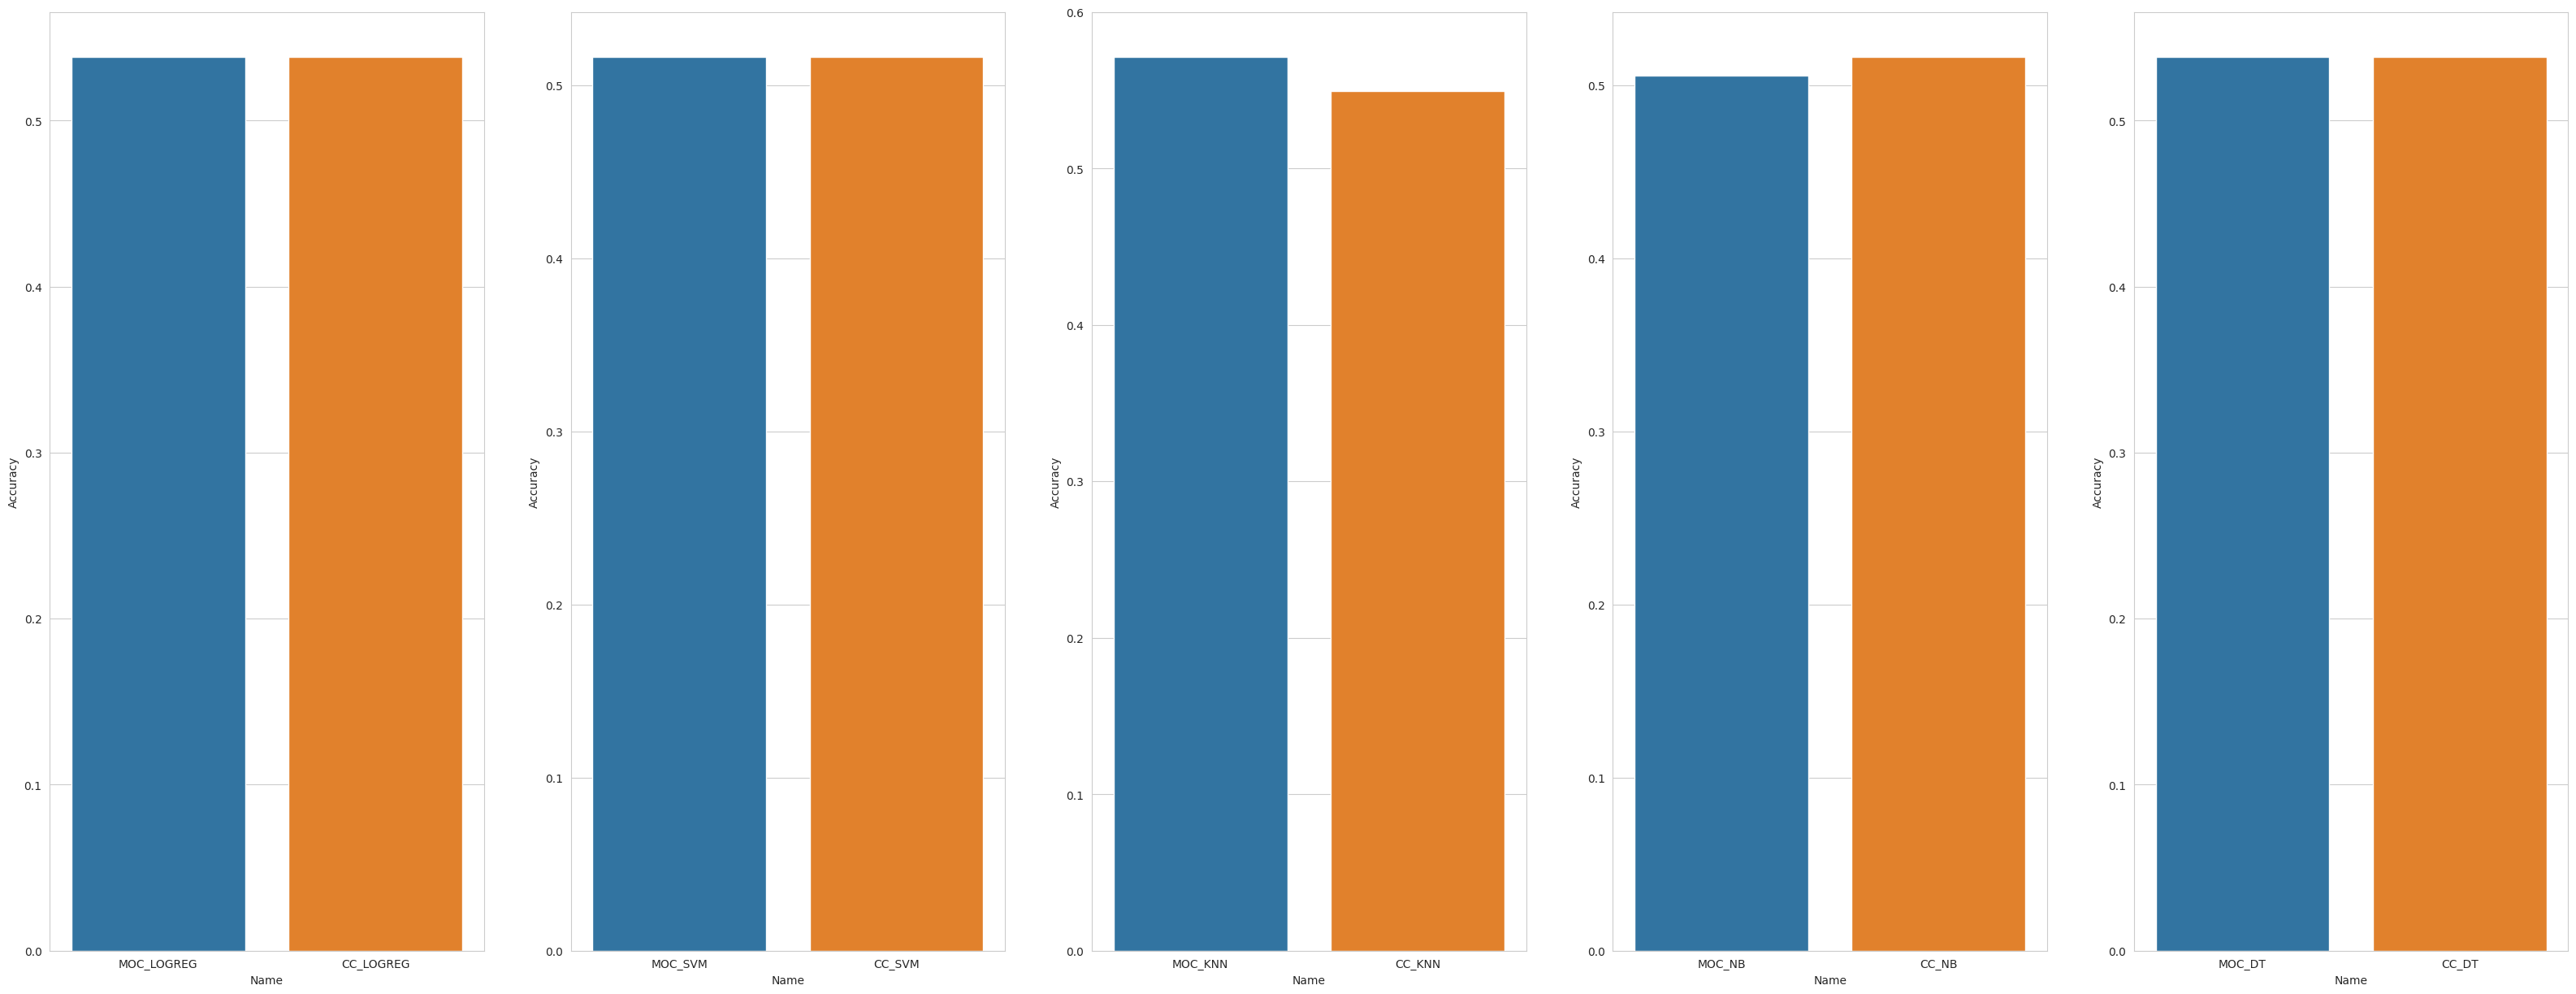

In [263]:
fig, axs = plt.subplots(ncols=5, figsize=(40, 15))
sns.barplot(accuracy_logreg_df, x='Name', y='Accuracy', palette="tab10", ax=axs[0])
sns.barplot(accuracy_svm_df, x='Name', y='Accuracy', palette="tab10", ax=axs[1])
sns.barplot(accuracy_knn_df, x='Name', y='Accuracy', palette="tab10", ax=axs[2])
sns.barplot(accuracy_nb_df, x='Name', y='Accuracy', palette="tab10", ax=axs[3])
sns.barplot(accuracy_dt_df, x='Name', y='Accuracy', palette="tab10", ax=axs[4])
plt.show()

### Время

In [264]:
time_logreg_df = pd.DataFrame(list(zip(names[0:2], times[0:2])), columns=['Name', 'Time'])
time_svm_df = pd.DataFrame(list(zip(names[2:4], times[2:4])), columns=['Name', 'Time'])
time_knn_df = pd.DataFrame(list(zip(names[4:6], times[4:6])), columns=['Name', 'Time'])
time_nb_df = pd.DataFrame(list(zip(names[6:8], times[6:8])), columns=['Name', 'Time'])
time_dt_df = pd.DataFrame(list(zip(names[8:10], times[8:10])), columns=['Name', 'Time'])

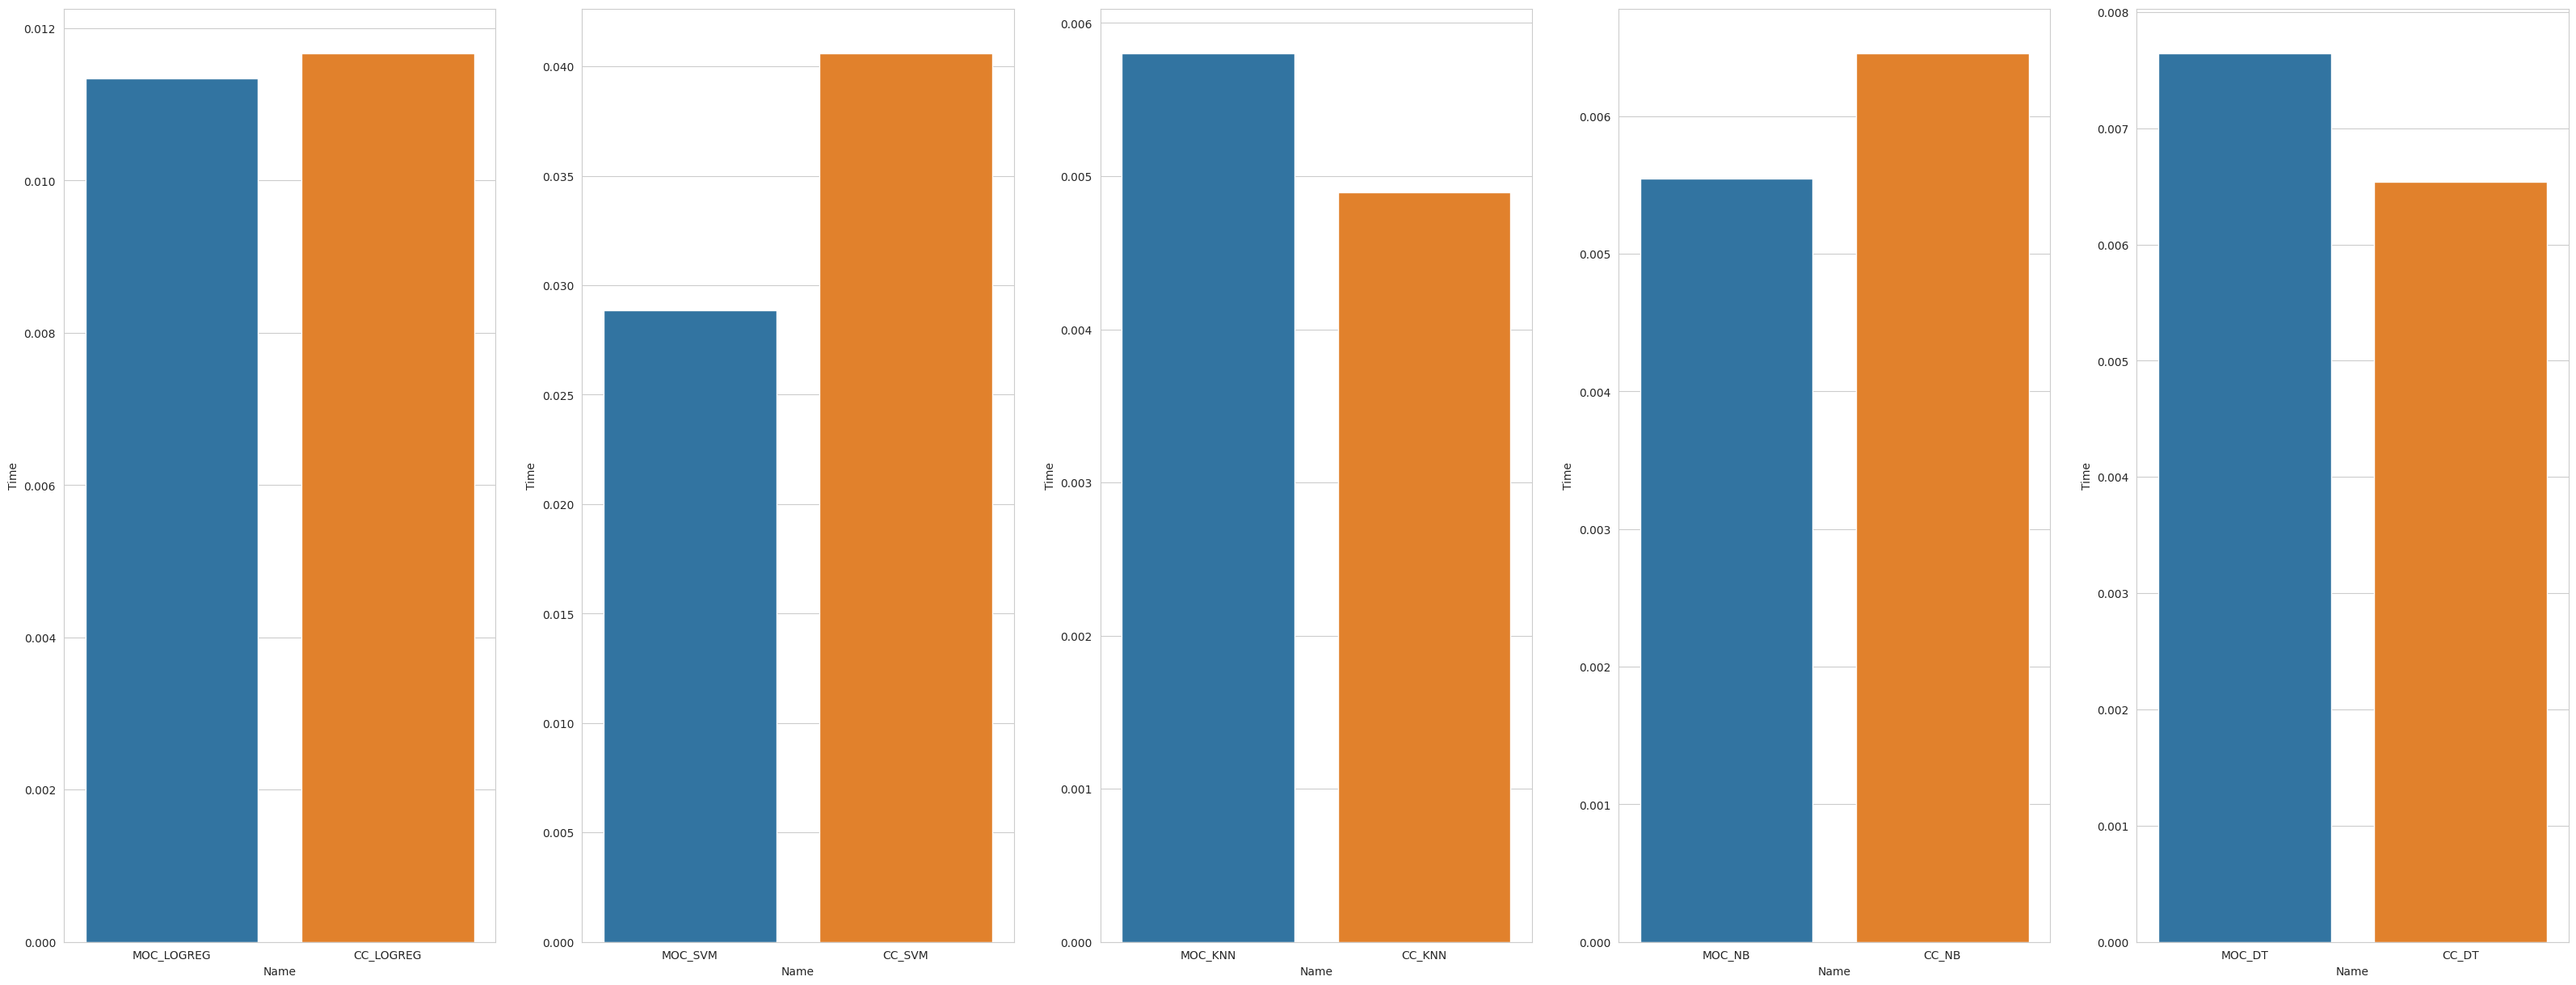

In [265]:
fig, axs = plt.subplots(ncols=5, figsize=(40, 15))
sns.barplot(time_logreg_df, x='Name', y='Time', palette="tab10", ax=axs[0])
sns.barplot(time_svm_df, x='Name', y='Time', palette="tab10", ax=axs[1])
sns.barplot(time_knn_df, x='Name', y='Time', palette="tab10", ax=axs[2])
sns.barplot(time_nb_df, x='Name', y='Time', palette="tab10", ax=axs[3])
sns.barplot(time_dt_df, x='Name', y='Time', palette="tab10", ax=axs[4])
plt.show()

Вывод:
По точности примерно все методы показали примерно сравнимый результат, однако наилучший результат показал метод MultiOutputClassifier с алгоритмом KNN.
Если выбирать с учетом времени выполнения, то самым быстрым является ClassifierChain с алгоритмом KNN, который не сильно уступает в точности MultiOutputClassifier.

# 3.Multioutput Regression

Описание датасета, скачать можно [тут](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

Целевыми признаками выберем два вещественных признака 'total_rooms', 'median_house_value'. Таким образом, найдем взаимосвязь предсказания по полям стоимости дома и количества комнат в нем.

In [266]:
df = pd.read_csv('/content/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## EDA

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [268]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

При общем количестве записей в 20640 значений, пропуски в total_bedrooms составляют всего 1%. Удалим их.

In [269]:
df = df.dropna()

In [270]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Больше нулевых значений в полях нет - замену делать не нужно.

Удалим некоррелируемое строковое поле.

In [271]:
df = df.drop(columns=['ocean_proximity'])

Некоторая статистика по целевым признакам.

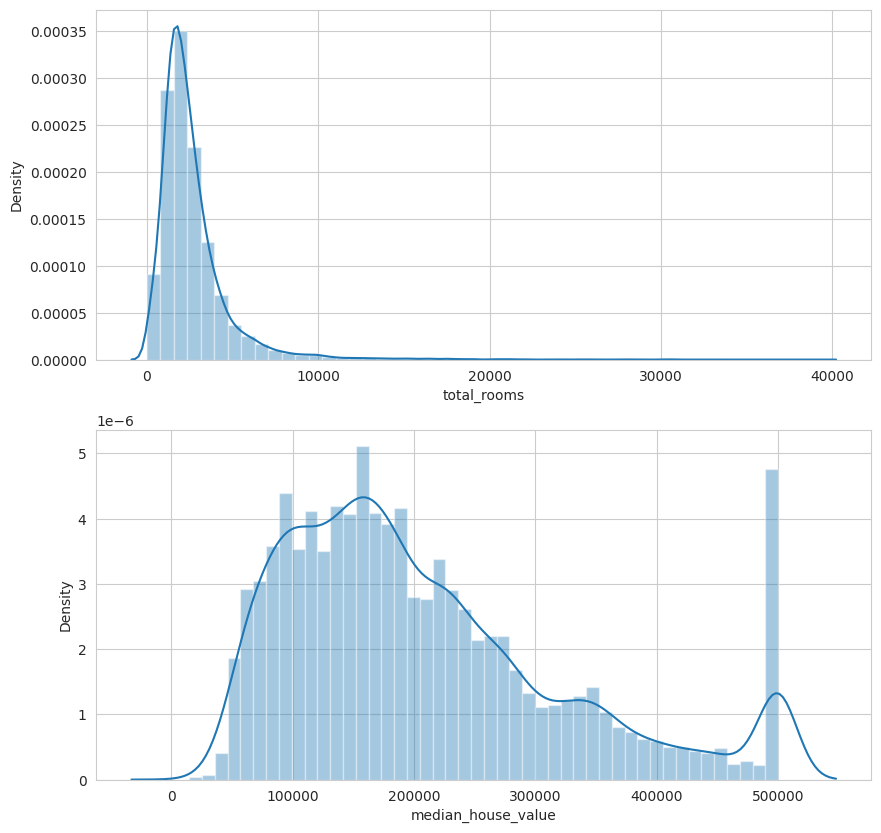

In [272]:
_, ax = plt.subplots(2, 1, figsize=(10,10))
sns.distplot(df['total_rooms'], ax=ax[0])
sns.distplot(df['median_house_value'], ax=ax[1])
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

Выведем матрицу корреляции

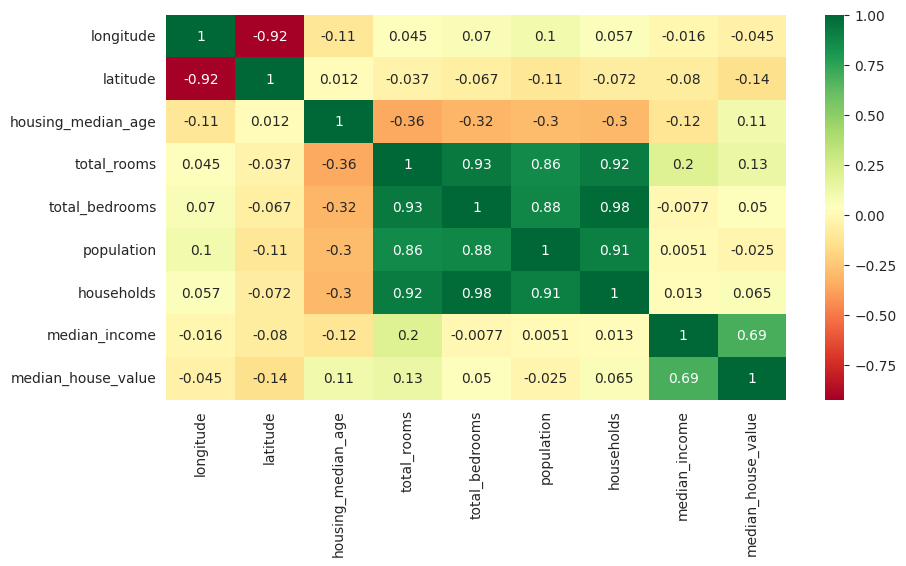

In [273]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Видим, что поля total_bedrooms, total_rooms, households и population - по сути означают одно и то же, заселенность жилой единицы дома. И поэтому сильно кореллируют. Удалим их все, кроме total_rooms.

In [274]:
df = df.drop(columns=["total_bedrooms", "households", "population"])

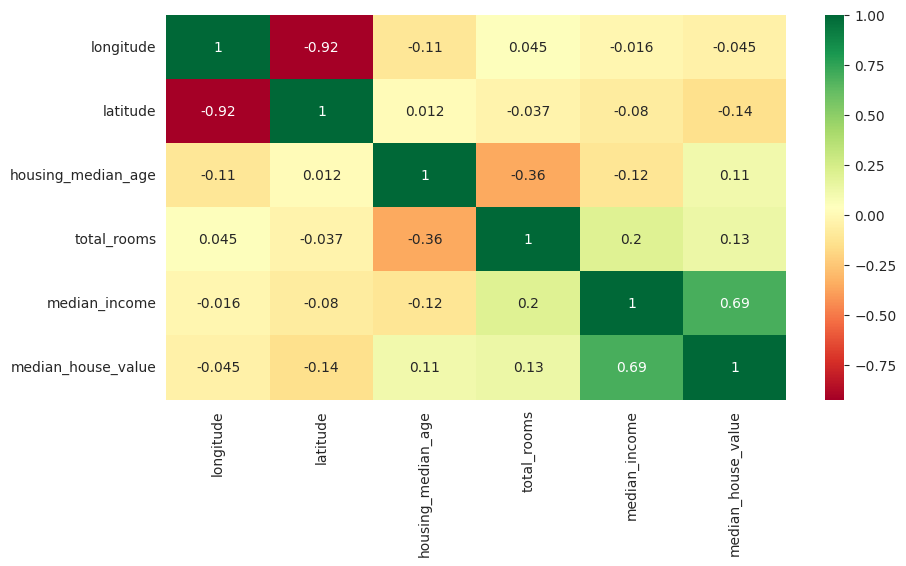

In [275]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

In [276]:
y = df[['total_rooms', 'median_house_value']]
X = df.drop(columns=['total_rooms', 'median_house_value'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=128)

scaler = StandardScaler()

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [277]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [278]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(X_train, y_train)

features =  X_train.columns[rfecv.support_]
print("Наилучшее количество признаков -", rfecv.n_features_)
print("Наиболее подходящие признаки -", features)

Наилучшее количество признаков - 4
Наиболее подходящие признаки - Index(['longitude', 'latitude', 'housing_median_age', 'median_income'], dtype='object')


In [279]:
X_train, X_test = X_train[features], X_test[features]

In [280]:
cv = StratifiedKFold(5, shuffle=True, random_state=128)

### Подберем гиперпараметры

In [281]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha_grid = np.logspace(-3, 3, 100)
tol_grid = np.logspace(-3, 3, 10)

searcher = GridSearchCV(
    Ridge(),
    [{"alpha": alpha_grid, "tol": tol_grid}],
    scoring="neg_root_mean_squared_error",
    cv=5,
)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
best_tol = searcher.best_params_["tol"]

print("Alpha = %.4f" % best_alpha)
print("Tol = %.4f" % best_tol)

Alpha = 2.1544
Tol = 0.0010


### Тестирование моделей

In [282]:
from sklearn.model_selection import cross_validate
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import r2_score

results = {}
times = {}

In [283]:
mor = MultiOutputRegressor(Ridge(alpha=best_alpha, tol=best_tol))
mor.fit(X_train.to_numpy(), y_train.to_numpy())
result = r2_score(y_test, mor.predict(X_test))
time = cross_validate(mor, X_train, y_train, cv=5)["fit_time"].mean()

results["MOR_RIDGE"] = result
times["MOR_RIDGE"] = time

print(f"result: {result}")
print(f"time: {time}")

result: 0.3747047407131704
time: 0.010393190383911132


In [284]:
rc = RegressorChain(Ridge(alpha=0.4037, tol=0.0010))
rc.fit(X_train.to_numpy(), y_train.to_numpy())
result = r2_score(y_test, rc.predict(X_test))
time = cross_validate(rc, X_train, y_train, cv=5)["fit_time"].mean()

results["RC_RIDGE"] = result
times["RC_RIDGE"] = time

print(f"result: {result}")
print(f"time: {time}")

result: 0.37470060834080865
time: 0.033965253829956056


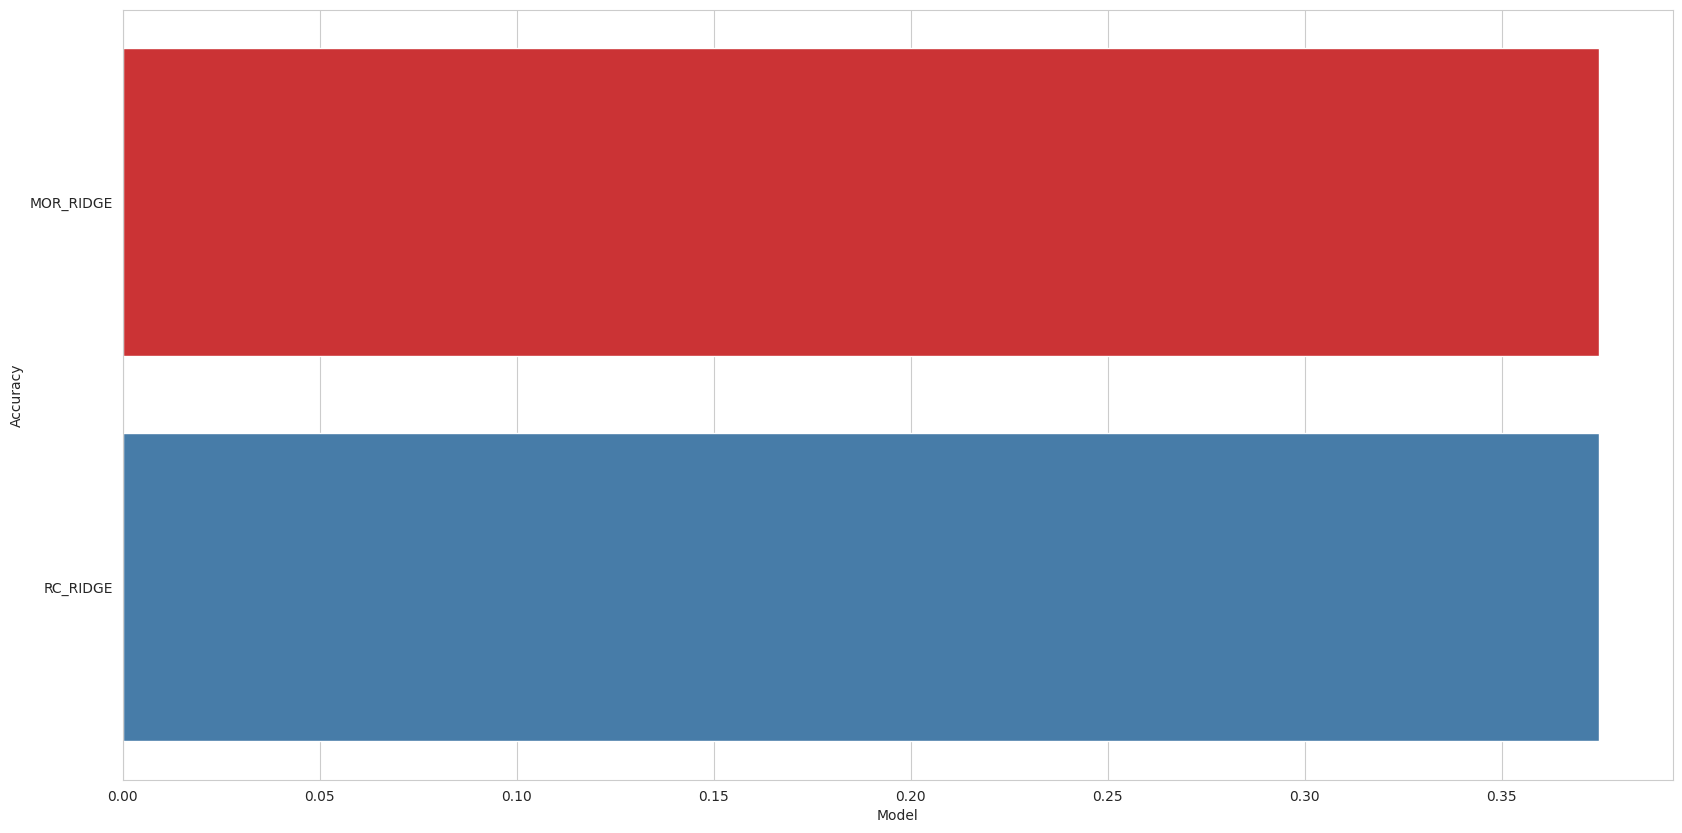

In [285]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(results.values()), y=list(results.keys()), palette=sns.color_palette("Set1", len(times)))
plt.show()

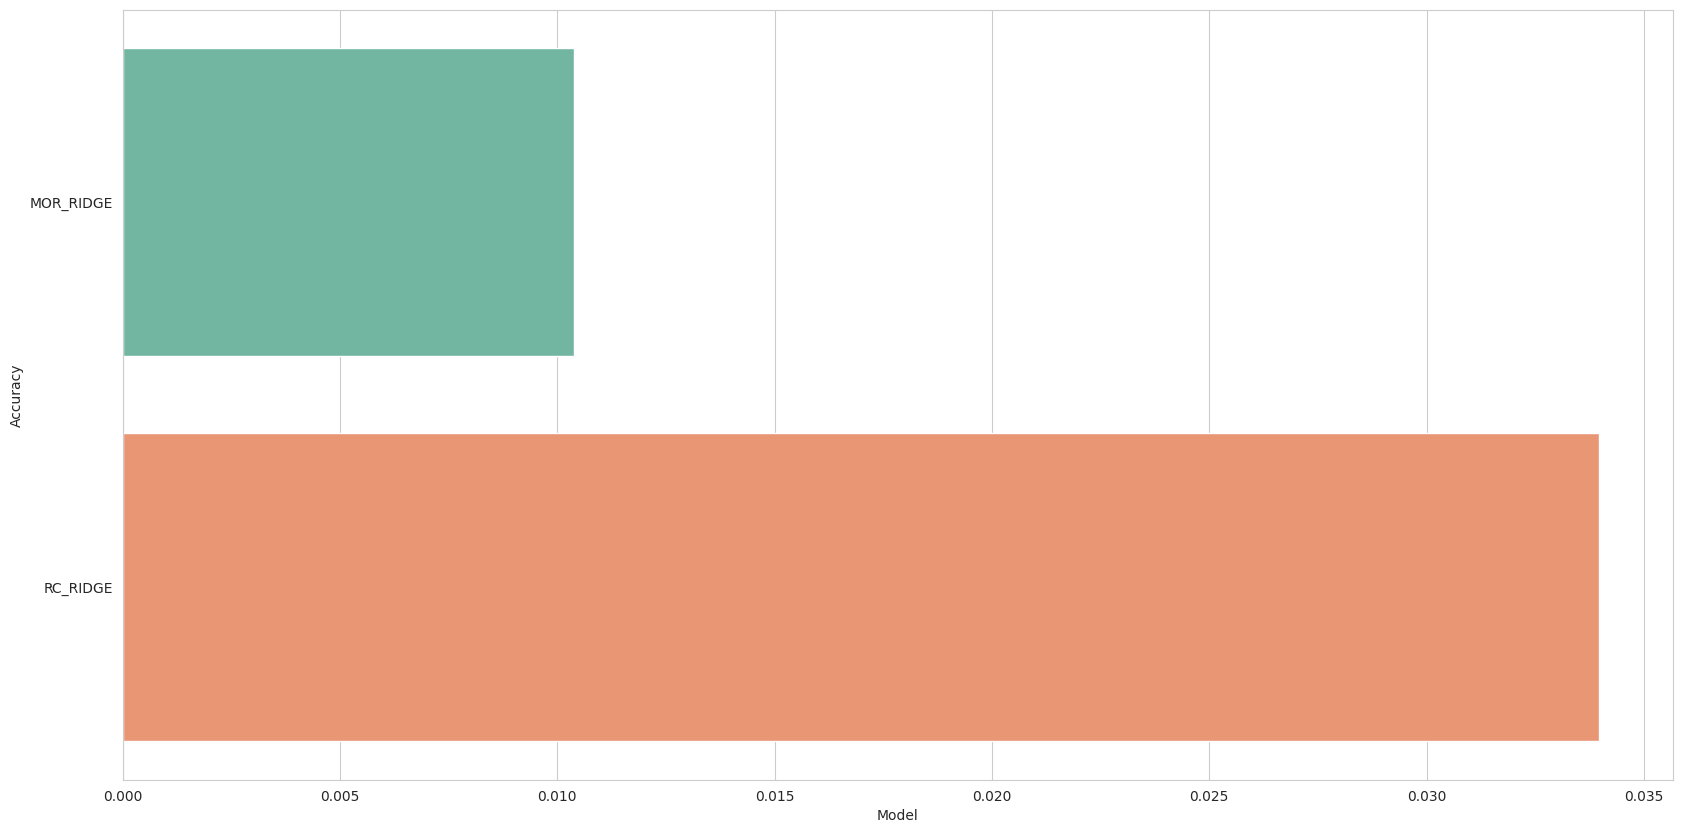

In [286]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(times.values()), y=list(times.keys()), palette=sns.color_palette("Set2", len(times)))
plt.show()

Вывод: MultiOutputRegressor и RegressorChain являются сравнимыми по точности для данного датасета. Однако MultiOutputRegressor намного выигрывает во времени выполнения. А значит этот метод более предпочтителен для предсказания.